In [4]:
import dynamiqs as dq
from functools import reduce
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
from scipy.linalg import expm, sinm, cosm
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display

|██████████| 100.0% ◆ elapsed 237.43ms ◆ remaining 0.00ms  


/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


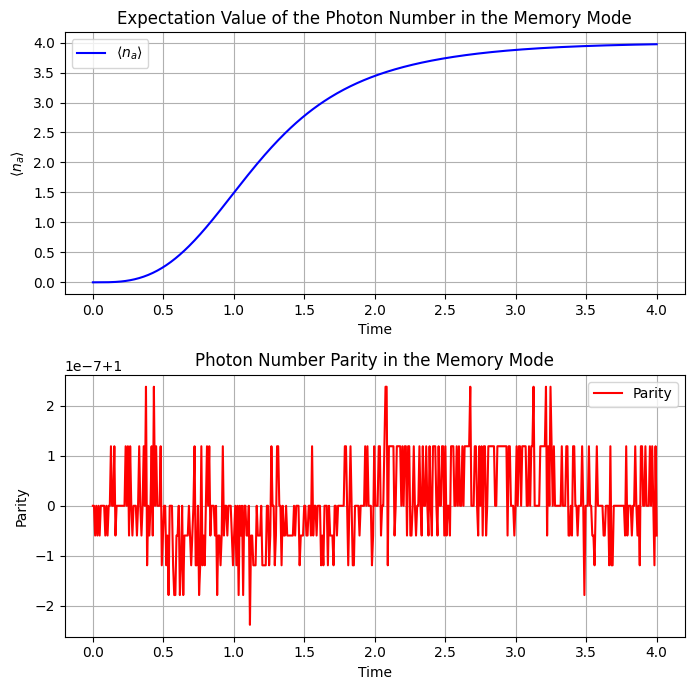

In [5]:
## Task 1.1 - Getting started with 'dynamiqs'
# Hilbert space truncations
na = 20  # Memory mode a - encodes the logical cat qubit
nb = 5   # Buffer mode b - mediates 2-photon dissipation to stabilize the cat state

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Memory mode a annihilation operator
adag = a.dag()                                # Memory mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Buffer mode b annihilation operator
bdag = b.dag()                                # Buffer mode b creation operator

# More parameters
g_2 = 1.0                          # 2-photon exchange coupling strength between the memory and buffer modes
eps_d = -4.0                       # Coherent drive applied to the buffer mode
kappa_b = 10 * g_2                 # Decay rate of the buffer mode
n_a = adag @ a                     # Photon number operator for the memory mode
T = 4                              # Time for simulation [s]
t_save = jnp.linspace(0, T, 500)   # Time array for the master equation to return with. Used with 500 intervals

# Hamiltonian construction
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)   # 2-photon exchange Hamiltonian - couples the memory and buffer modes
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag                           # 1-photon drive Hamiltonian - supplies the photons so that the memory mode can end up in a cat state
H = H_2ph + H_d                                                         # Stabilized Hamiltonian

# Initial state, collapse operator, & resulting states
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))   # Vacuum state initialization - creates the memory and buffer modes with 0 photons each
c_ops = [jnp.sqrt(kappa_b) * b]                    # Collapse operator on the buffer mode - 1-photon loss as a result of decay from this operator
result = dq.mesolve(H, c_ops, psi0, t_save)        # Solves the Lindblad master equation - returns the time evolution of the density matrix for each time step   

# Parity and expectation values
terms_a = [(-1)**n * dq.fock_dm(na, n) for n in range(na)]                  # Creates Fock-state projectors with alternating signs
parity_a_local = reduce(lambda x, y: x + y, terms_a)                        # The actual memory mode parity operator - returns +1 when number of photons is even and -1 when odd
parity_a = dq.tensor(parity_a_local, dq.eye(nb))                            # Embeds the memory mode parity operator into the full 2-mode Hilbert space - This is basically the parity operator on the memory mode and leaves the buffer mode the same
n_a_expect = [dq.expect(n_a, state) for state in result.states]             # Calculates the expectation value from the resulting states using the photon number operator for the memory mode
parity_a_expect = [dq.expect(parity_a, state) for state in result.states]   # Calculates the expectation value from the resulting states using the parity operator for the memory mode

# Animation plotting
fig_w, ax_w = plt.subplots(1, 1, figsize=(7, 7)) 
def update(frame):
    ax_w.cla()                                   # Clears the axis
    rho_a = dq.ptrace(result.states[frame], 0)   # Partial trace over the buffer mode to extract the reduced state of the memory mode
    dq.plot.wigner(rho_a, ax=ax_w)               # Plots the Wigner function for the reduced state above, rho_a
    ax_w.set_title(f'Memory Mode of the Wigner Function\nna = {na}, nb = {nb}, & Time = {t_save[frame]:.2f}')   # Sets the title of the animation

ani = FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)   # Creates the animation
gif_filename = f'Task 1.1 with {na}.{nb}.gif'                          # Animation file name
ani.save(gif_filename, writer=PillowWriter(fps=50))                    # Saves the animation to the same directory that this file is in
plt.close(fig_w)                                                       # Closes the file in matplotlib to free up memory 
display(HTML(f'<img src="{gif_filename}">'))                           # Displays the animation file

# Plotting the expectation value of the photon number in the memory mode
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.plot(t_save, n_a_expect, label=r'$\langle n_a \rangle$', color='blue')   # Creates the expectation value plot
ax1.set_title('Expectation Value of the Photon Number in the Memory Mode')   # Sets the title of the plot
ax1.set_xlabel('Time')                                                       # Sets the x label for the plot
ax1.set_ylabel(r'$\langle n_a \rangle$')                                     # Sets the y label for the plot
ax1.legend()                                                                 # Adds a legend to the plot
ax1.grid(True)                                                               # Adds a grid to the plot

# Plotting the photon number parity in the memory mode
ax2.plot(t_save, parity_a_expect, label='Parity', color='red')   # Creates the photon number parity plot of the memory mode
ax2.set_title('Photon Number Parity in the Memory Mode')         # Sets the title of the plot
ax2.set_xlabel('Time')                                           # Sets the x label for the plot
ax2.set_ylabel('Parity')                                         # Sets the y label for the plot
ax2.legend()                                                     # Adds a legend to the plot
ax2.grid(True)                                                   # Adds a grid to the plot

plt.tight_layout()   # Adjusts spacing between plotted elements
plt.show()           # Shows all plots

|██████████| 100.0% ◆ elapsed 243.99ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 311.04ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 231.14ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 112.09ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 215.08ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 80.67ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 205.10ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 73.46ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 234.04ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 56.70ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 212.60ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 25.42ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 232.29ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 25.90ms ◆ remaining 0.00ms


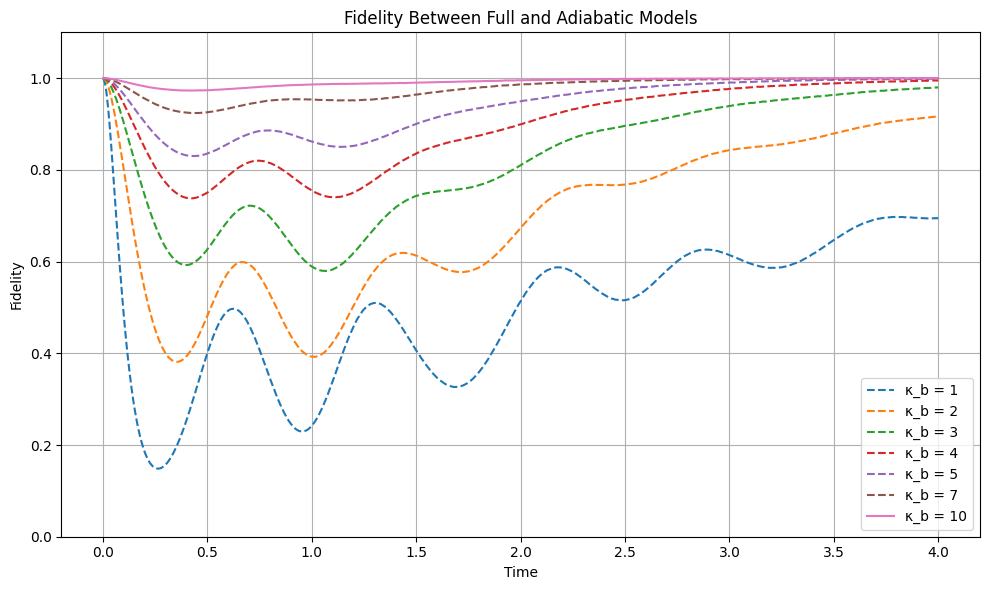

In [6]:
## Task 1.2 - Comparison with eliminated buffer mode
# Hilbert space truncations
na = 20   # Memory mode a - encodes the logical cat qubit
nb = 5    # Buffer mode b - mediates 2-photon dissipation to stabilize the cat state

# More parameters
g_2 = 1.0                          # 2-photon exchange coupling strength between the memory and buffer modes
eps_d = -4.0                       # Coherent drive applied to the buffer mode
T = 4                              # Time for simulation [s]
t_save = jnp.linspace(0, T, 500)   # Time array for the master equation to return with. Used with 500 intervals

# kappa_b values to test and compare with original value from Task 1.1
kappa_b_values = jnp.array([1, 2, 3, 4, 5, 7, 10])

# Plotting
plt.figure(figsize=(10, 6))
for kappa_b in kappa_b_values:
    # Operators in the composite Hilbert space
    a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Memory mode a annihilation operator
    adag = a.dag()                                # Memory mode a creation operator
    b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Buffer mode b annihilation operator
    bdag = b.dag()                                # Buffer mode b creation operator
    
    # Hamiltonian construction
    H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)   # 2-photon exchange Hamiltonian - couples the memory and buffer modes
    H_d = jnp.conjugate(eps_d) * b + eps_d * bdag                           # 1-photon drive Hamiltonian - supplies the photons so that the memory mode can end up in a cat state
    H = H_2ph + H_d                                                         # Stabilized Hamiltonian 
    
    # Initial state, collapse operator, resulting states, & final memory mode information
    psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))                # Vacuum state initialization - creates the memory and buffer modes with 0 photons each
    c_ops = [jnp.sqrt(kappa_b) * b]                                 # Collapse operator on the buffer mode - 1-photon loss as a result of decay from this operator
    result = dq.mesolve(H, c_ops, psi0, t_save)                     # Solves the Linblad master equation - returns the time evolution of the density matrix for each time step   
    rho_a_list = [dq.ptrace(state, 0) for state in result.states]   # Get reduced states of the memory mode by discarding the buffer mode's quantum information

    # Effective parameters
    kappa_2 = 4 * abs(g_2)**2 / kappa_b      # 2-photon dissipation rate
    alpha_sq = -eps_d / jnp.conjugate(g_2)   # Squared coherent‐state amplitude
    alpha = jnp.sqrt(alpha_sq)               # Target coherent-state amplitude
    
    # Effective operators
    a_eff = dq.destroy(na)                                                # Effective single-mode annihilation operator - acts on the memory mode in the adiabatically eliminated model
    L_eff = jnp.sqrt(kappa_2) * (a_eff @ a_eff - alpha_sq * dq.eye(na))   # Effective memory mode collapse operator - responsible for stabilization
    
    # Effective system results and fidelity
    result_eff = dq.mesolve(dq.zeros(na), [L_eff], dq.fock(na, 0), t_save)   # Solves the effective 1-mode system and returns a list of density matrices
    fidelity = [dq.fidelity(rho_a, rho_eff)                                  # Captures how close the memory mode from the full simulation is to the 1‐mode
                for rho_a, rho_eff in zip(rho_a_list, result_eff.states)]    # solution from the adiabatically eliminated approach at each time step
    
    # Plot results
    plt.plot(t_save, fidelity, label=f'κ_b = {kappa_b}',
             linestyle='--' if kappa_b < 10 else '-')

# Plot formatting
plt.xlabel('Time')                                        # Sets the x label for the plot
plt.ylabel('Fidelity')                                    # Sets the y label for the plot
plt.ylim(0, 1.1)                                          # Sets the y limits for the plot
plt.title('Fidelity Between Full and Adiabatic Models')   # Sets the title of the plot
plt.legend()                                              # Adds a legend to the plot
plt.grid(True)                                            # Adds a grid to the plot

plt.tight_layout()   # Adjusts spacing between plotted elements
plt.show()           # Shows all plots

|██████████| 100.0% ◆ elapsed 545.32ms ◆ remaining 0.00ms  


/opt/anaconda3/envs/qc/lib/python3.12/site-packages/equinox/_module.py:1096: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a scalar.
  return self.__func__(self.__self__, *args, **kwargs)
/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qc/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


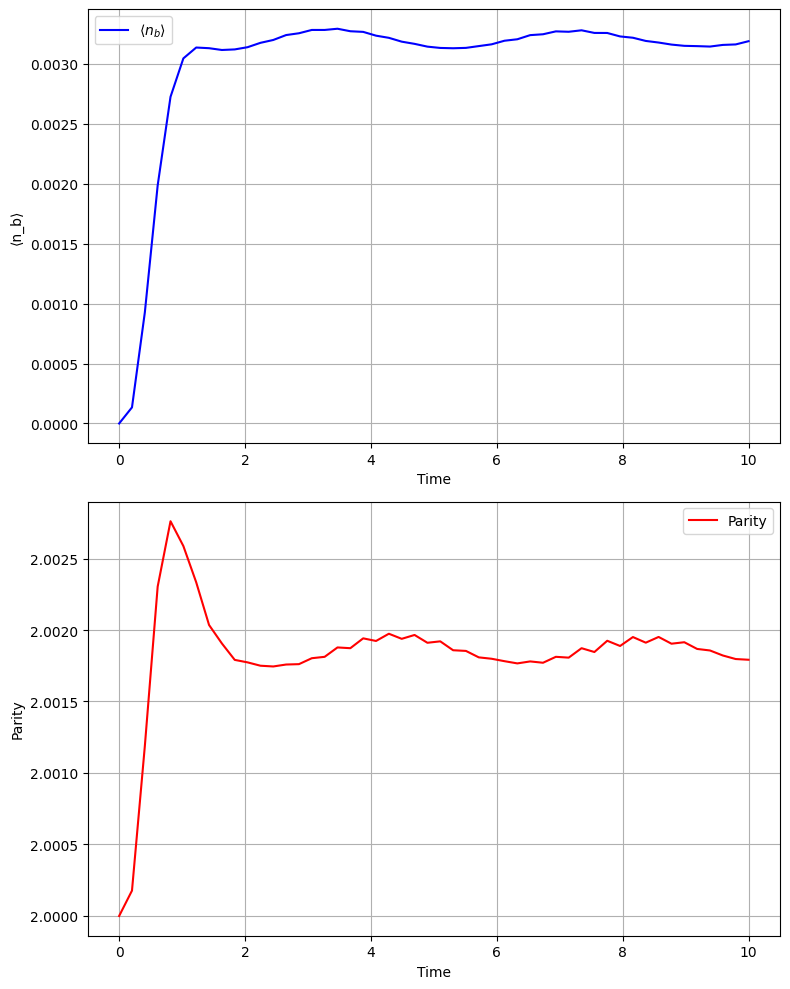

In [7]:
## Task 1.3 - Performing a Zeno-gate
# Hilbert-space truncations
na = 20   # Buffer mode a
nb = 5    # Memory mode b
g_2 = 1.0                          # 2-photon exchange coupling strength between the memory and buffer modes
eps_d = -4.0 + 0j                      # Coherent drive applied to the buffer mode
kappa_b = 10                 # Decay rate of the buffer mode
alpha = 2

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))     # Mode a annihilation operator
# a = dq.tensor(dq.destroy(na), dq.zeros(nb))     # Mode a annihilation operator
adag = a.dag()                                # Mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))     # Mode b annihilation operator
# b = dq.tensor(dq.zeros(na), dq.destroy(nb))     # Mode b annihilation operato
bdag = b.dag()                                # Mode b creation operator

# Define the bosonic operator O = a† b
# O = adag @ a + bdag @ b - bdag @ b @ adag @ a - bdag @ bdag @ b @ b - adag @ adag @ a @ a
O = adag @ b

# Define the Hermitian Hamiltonian for the Zeno gate
epsilon_Z = 0.2 + 0j  # Choose an appropriate strength
# H_Z = jnp.conjugate(epsilon_Z) * O + epsilon_Z * O.dag()  # Ensures Hermiticity
# H_Z = jnp.conjugate(epsilon_Z) * a + epsilon_Z * a.dag()  # Ensures Hermiticity
H_Z = epsilon_Z * (adag + a)
# H_Z = adag @ a + bdag @ b - bdag @ b @ adag @ a - bdag @ bdag @ b @ b - adag @ adag @ a @ a
# H_Z = epsilon_Z * (expm(a @ bdag) + expm(adag @ b))

# Add other interaction Hamiltonians if required
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)   # 2-photon exchange Hamiltonian - couples the memory and buffer modes
H_d = jnp.conjugate(eps_d) * b + eps_d * bdag                           # 1-photon drive Hamiltonian - supplies the photons so that the memory mode can end up in a cat state
H = H_2ph + H_d + H_Z
# H = jnp.conjugate(epsilon_Z) * O + epsilon_Z * O.dag() +  g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag) + jnp.conjugate(eps_d) * b + eps_d * bdag 
# H = H_Z
# Initialize to the |+⟩ state in the composite system (mode a and b)

cat_plus_a = dq.unit(dq.coherent(na, alpha) + dq.coherent(na, -alpha))  # Even cat state in mode a
cat_plus_b = dq.unit(dq.coherent(nb, alpha) + dq.coherent(nb, -alpha))
cat_minus_a = dq.unit(dq.coherent(na, alpha) - dq.coherent(na, -alpha))  # Even cat state in mode a
cat_minus_b = dq.unit(dq.coherent(nb, alpha) - dq.coherent(nb, -alpha))
psi0 = dq.tensor(cat_plus_a, dq.fock(nb, 0))  # |+⟩ state for mode a, vacuum for mode b
# psi0 = dq.tensor(cat_plus_a, cat_plus_b)
# psi0 = dq.tensor(cat_minus_a, cat_minus_b)

# Create time array
T = 10  # Simulation time
t_save = np.linspace(0, T, 50)

# Collapse operators (optional)
c_ops = [jnp.sqrt(kappa_b) * b]     # Some decay on mode b
# c_ops = [0 * b]

# Solve the Lindblad equation
res = dq.mesolve(H, c_ops, psi0, t_save)

# -------------------------------
# 10. Create the GIF: Compute the Wigner function of the memory mode (by tracing out the buffer)
# -------------------------------
fig_w, ax_w = plt.subplots(1, 1, figsize=(6, 6))
def update(frame):
    ax_w.cla()  # Clear previous frame
    # Extract the reduced density matrix for the memory mode:
    rho_a = dq.ptrace(res.states[frame], 0)
    # Plot the Wigner function for the memory mode:
    dq.plot.wigner(rho_a, ax=ax_w)
    ax_w.set_title(f"Memory Mode Wigner Function\nTime = {t_save[frame]:.2f}")

ani = FuncAnimation(fig_w, update, frames=len(t_save), repeat=False)
gif_filename = 'wigner_memory_mode_Zeno.gif'
ani.save(gif_filename, writer=PillowWriter(fps=50))

plt.close(fig_w)
display(HTML(f'<img src="{gif_filename}">'))



# Check evolution by plotting expectation values of photon number and parity in mode b
n_b = bdag @ b
# Build the parity operator for mode b
parity_b_local = dq.zeros(nb)  # Initialize zero matrix in mode b
for n in range(nb):
    parity_b_local = parity_b_local.addscalar((-1)**n) + dq.fock_dm(nb, n)

# Now, tensor with the identity for mode a.
parity_b = dq.tensor(dq.eye(na), parity_b_local)


n_b_expect = [dq.expect(n_b, state) for state in res.states]
parity_b_expect = [dq.expect(parity_b, state) for state in res.states]

# Plot the expectation value and parity for mode b
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot the expectation value of the photon number in mode b.
ax1.plot(t_save, n_b_expect, label=r'$\langle n_b \rangle$', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('⟨n_b⟩')
ax1.legend()
ax1.grid(True)

# Plot the photon number parity in mode b.
ax2.plot(t_save, parity_b_expect, label='Parity', color='red')
ax2.set_xlabel('Time')
ax2.set_ylabel('Parity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
## Task 1.4 - Optimal control for state-preparation
# Hilbert space truncations
na = 20   # Memory mode a - encodes the logical cat qubit
nb = 5    # Buffer mode b - mediates 2-photon dissipation to stabilize the cat state

# Operators in the composite Hilbert space
a = dq.tensor(dq.destroy(na), dq.eye(nb))   # Memory mode a annihilation operator
adag = a.dag()                              # Memory mode a creation operator
b = dq.tensor(dq.eye(na), dq.destroy(nb))   # Buffer mode b annihilation operator
bdag = b.dag()                              # Buffer mode b creation operator

# More parameters
g_2 = 1.0        # 2-photon exchange coupling strength between the memory and buffer modes
kappa_b = 10.0   # Decay rate of the buffer mode
alpha = 2.0      # Target coherent-state amplitude so that alpha^2 = 4

# Create a piecewise constant time array 
T = 3.0                                 # Total simulation time [s]
N_bins = 10                             # Number of bins to divide the time into
t_bins = jnp.linspace(0, T, N_bins+1)   # Bin boundaries
dt = T / N_bins                         # Time step for each bin
# Also create a time array for final plotting if needed
t_save = jnp.linspace(0, T, 300)

# 2-photon Hamiltonian construction
H_2ph = g_2 * (adag @ adag @ b) + jnp.conjugate(g_2) * (a @ a @ bdag)   # 2-photon exchange Hamiltonian - couples the memory and buffer modes

# Initial state and collapse operator
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))   # Vacuum state initialization in both modes
c_ops = [jnp.sqrt(kappa_b) * b]                    # Collapse operator on the buffer mode (1-photon loss)

# Construct the target cat state for the memory mode
coherent_plus = dq.coherent(na, alpha)       # Coherent state |alpha> for the memory mode
coherent_minus = dq.coherent(na, -alpha)     # Coherent state |-alpha> for the memory mode
cat_state = coherent_plus + coherent_minus   # Unnormalized cat state
cat_even = dq.unit(cat_state)                # Normalized even cat state

# Loss function (loss = 1 - fidelity between the final memory state and the target cat state)
def loss_function(eps_d_values):
    state = psi0                                                     # Initialize the state as the vacuum state (full 2-mode system)
    for i in range(N_bins):                                          
        H_d = eps_d_values[i] * (b + bdag)                           # 1-photon drive Hamiltonian for this bin
        H = H_2ph + H_d                                              # Total Hamilitonian for this bin
        result = dq.mesolve(H, c_ops, state, jnp.array([0.0, dt]))   # Solve the Linblad master equation - returns the time evolution of the density matrix for each time step   
        state = result.states[-1]                                    # Updates the bin state with the final state from the list of density matrices (states)
    rho_a = dq.ptrace(state, 0)                                      # Partial trace over the buffer mode to extract the reduced state of the memory mode
    return 1.0 - dq.fidelity(rho_a, cat_even)                        # Returns the loss given the reduced density matrix and the normalized even cat state

# Initialize optimizer
opt_init, opt_update, get_params = adam(step_size=0.1)   # Configures an Adam optimizer with a fixed learning rate and returns values for opt_init, opt_update, & get_params
eps_d_init = -(alpha**2) * jnp.ones(N_bins)              # Initializes the piecewise drive amplitudes to a constant value across all bins
opt_state = opt_init(eps_d_init)                         # Sets up the internal Adam buffers used during gradient-based optimization
print("Initial loss =", loss_function(eps_d_init))       # Prints the initial loss to see how it evolves with time

# JIT-compiled optimization step
@jax.jit   # The computer tells JAX to Just-In-Time (JIT) compile the step function
def step(opt_state): 
    params = get_params(opt_state)                                  # Extracts the piecewise drive amplitudes from the optimizer state
    loss_value, grads = jax.value_and_grad(loss_function)(params)   # Returns both the function’s value and its gradient with respect to the inputs, & returns the scalar loss
    opt_state = opt_update(0, grads, opt_state)                     # New updated optimizer state
    return opt_state, loss_value                                    # Returns the optimizer state and loss value to

# Run optimization
loss_history = []   # Empty array to record loss
for i in range(100):
    opt_state, loss_value = step(opt_state)                # Updates the optimizer state with one gradient step (Adam)
    loss_history.append(float(loss_value))                 # Appends the loss value to loss_history
    print(f"Iteration: {i:3d} | Loss: {loss_value:.4f}")   # Prints the iteration # with the loss value
eps_d_optimized = get_params(opt_state)                    # The final set of drive amplitudes that minimize the loss function

# Plotting loss history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(loss_history)                                  # Plots the loss
ax1.set_xlabel('Iteration')                             # Sets the x label for the plot
ax1.set_ylabel('Loss (1 - Fidelity)')                   # Sets the y label for the plot
ax1.set_yscale('log')                                   # Sets the y scale for the plot
ax1.grid(True)                                          # Adds a grid to the plot

# Plot optimized eps_d(t)
t_bins = jnp.linspace(0, T, N_bins, endpoint=False)   # Creates an array of N_bins equally spaced points from 0 up to but not including T
ax2.step(t_bins, eps_d_optimized, where='post')       # Creates a step graph for the optimized eps_d values
ax2.set_xlabel('Time')                                # Sets the x label for the plot
ax2.set_ylabel('$\\epsilon_d(t)$')                    # Sets the y label for the plot
ax2.grid(True)                                        # Adds a grid to the plot

plt.tight_layout()   # Adjusts spacing between plotted elements
plt.show()           # Shows all plots